In [1]:
import numpy as np
import pandas as pd
import torch, copy, random, time, cv2
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split

In [2]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataset Description

In [3]:
dataset_desc = pd.read_csv('kidneyData.csv', index_col = 0)

In [4]:
dataset_desc.sample(5)

,image_id,path,diag,target,Class
11348,Cyst- (2600),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
812,Tumor- (692),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1164,Tumor- (505),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3579,Normal- (2228),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Normal,1,Normal
8297,Stone- (1255),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Stone,2,Stone


In [5]:
dataset_desc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12446 entries, 0 to 12445
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  12446 non-null  object
 1   path      12446 non-null  object
 2   diag      12446 non-null  object
 3   target    12446 non-null  int64 
 4   Class     12446 non-null  object
dtypes: int64(1), object(4)
memory usage: 583.4+ KB


In [6]:
print("List of dataset features/columns: ")
print(list(dataset_desc.columns))       # List of column names

List of dataset features/columns: 
['image_id', 'path', 'diag', 'target', 'Class']


In [7]:
print("The record number of kidney image dataset", dataset_desc.shape[0])

The record number of kidney image dataset 12446


### Image Examples

There are 4 kidney image examples:
- **Cyst** image
- **Normal** image
- **Stone** image
- **Tumor** image

In [8]:
# Path to the image
image_path_cyst = "./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (6).jpg"
image_path_norm = "./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (6).jpg"
image_path_stone = "./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (6).jpg"
image_path_tumor = "./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (6).jpg"


# Load the image
img_cyst = cv2.imread(image_path_cyst, 1)
img_norm = cv2.imread(image_path_norm, 1)
img_stone = cv2.imread(image_path_stone, 1)
img_tumor = cv2.imread(image_path_tumor, 1)

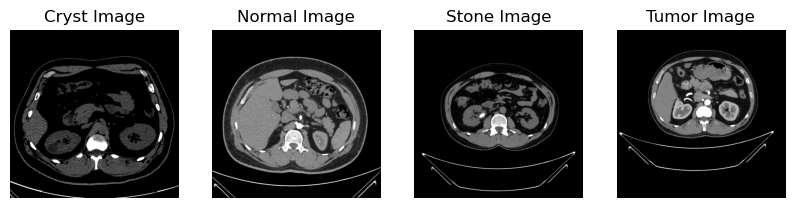

In [9]:
# Display
plt.figure(figsize=(10, 5))

# Cyst Image
plt.subplot(1, 4, 1), plt.title('Cryst Image')
plt.imshow(img_cyst)
plt.axis('off')  # Hide axes for better visualization

# Normal Image
plt.subplot(1, 4, 2), plt.title('Normal Image')
plt.imshow(img_norm)  # Clip and convert noise to uint8
plt.axis('off')

# Stone Image
plt.subplot(1, 4, 3), plt.title('Stone Image')
plt.imshow(img_stone)
plt.axis('off')

# Tumor Image
plt.subplot(1, 4, 4), plt.title('Tumor Image')
plt.imshow(img_tumor)
plt.axis('off')

plt.show()

### Custom Image Dataset

In [10]:
class CT_KidneyDataset(Dataset):
    def __init__(self, csv_file, root_dir, num_classes = 4, file_format = ".jpg", transform=None):
        """
        Args:
            csv_file (str): Path to the csv file with image paths and labels.
            root_dir (str): Directory containing all images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.file_format = file_format
        self.transform = transform
        self.num_classes = num_classes

        """Extract file paths and its labels"""
        self.image_paths = self.root_dir + self.data_frame["Class"].values + "/" + self.data_frame["image_id"].values + self.file_format # Extract file_paths
        self.labels = self.data_frame['target'].values  # Extract labels

    def __len__(self):
        """Returns the total number of images in the dataset"""
        return len(self.data_frame)

    def __getitem__(self, idx):
        """Loads and returns an image and its one-hot encoded label at the given index"""

        # Get the image path and label
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load the image
        image = Image.open(img_path).convert("RGB")  # Convert to RGB

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
    
        # Convert label to one-hot encoding if num_classes > 1
        one_hot_label = torch.zeros(self.num_classes)
        one_hot_label[label] = 1
        
        return image, one_hot_label

Configure root directory, csv file and torchvision transform class

In [11]:
root_dir = "./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/"
csv_file = "kidneyData.csv"
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Load **Kidney dataset** in Custom Dataset

In [12]:
kidney_image_data = CT_KidneyDataset(csv_file = csv_file, root_dir = root_dir, transform = transform)

Display one of the kidney image

In [13]:
def display_tensor_image(tensor_image):
    """
    Display an image from a PyTorch tensor using matplotlib.

    Args:
        tensor_image (torch.Tensor): The image in a PyTorch tensor format (C, H, W).
    """
    # Ensure the tensor is in the right format (C, H, W -> H, W, C)
    image_np = tensor_image.permute(1, 2, 0).numpy()  # Convert from CHW to HWC
    
    # If the tensor values are between [0, 1], convert to [0, 255]
    if image_np.max() <= 1.0:
        image_np = (image_np * 255).astype(np.uint8)
    
    # Display the image using matplotlib
    plt.imshow(image_np)
    plt.axis('off')  # Hide the axes
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


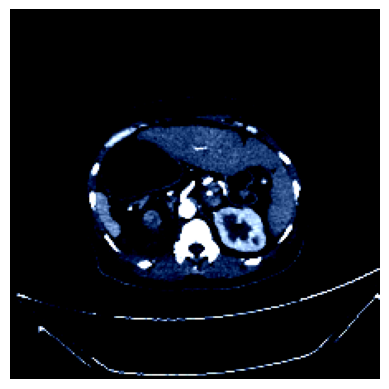

In [14]:
display_tensor_image(kidney_image_data[100][0])

**Training & Testing** Dataset:
- Split into training and testing dataset
- Create dataloaders

In [15]:
# Configure batch size and num of workers
batch_size = 16
num_workers = 0

# Split the dataset
train_size = int(0.6 * len(kidney_image_data))  # 60% for training
test_size = len(kidney_image_data) - train_size  # 40% for testing
train_dataset, test_dataset = random_split(kidney_image_data, [train_size, test_size])

# Create DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers = num_workers)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers = num_workers)

In [16]:
# Number of records (samples) in the training and testing datasets
print("The record number of training dataset:", len(train_dataset))
print("The record number of testing dataset:", len(test_dataset))

# Number of batches in the training and testing dataloaders
print("The number of batches in the training dataset:", len(train_loader))
print("The number of batches in the testing dataset:", len(test_loader))

The record number of training dataset: 7467
The record number of testing dataset: 4979
The number of batches in the training dataset: 467
The number of batches in the testing dataset: 312


### Create Neural Network

In [17]:
class baseline_CNN(nn.Module):
    def __init__(self, num_classes = 4):
        super(baseline_CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Layer 1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # Layer 2
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer (applied after conv layers)
        
        # Additional convolutional layers
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) # Layer 3
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1) # Layer 4
        
        # Flatten layer
        self.flatten = nn.Flatten()  # Automatically flattens the feature maps
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 512)  # Adjust input size based on input image dimensions
        self.fc2 = nn.Linear(512, 128)  # Layer 5
        self.fc3 = nn.Linear(128, num_classes)  # Layer 6 (output layer)
    
    def forward(self, x):
        # Block 1: Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x)))
        
        # Block 2: Conv2 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))
        
        # Block 3: Conv3 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv3(x)))
        
        # Block 4: Conv4 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv4(x)))
        
        # Flatten the feature maps for the fully connected layers
        x = self.flatten(x)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for the output layer (use softmax in loss function if needed)
        
        return x

In [18]:
cnn_model = baseline_CNN()
cnn_model = cnn_model.to(device)

In [19]:
# Print the summary
summary(cnn_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Conv2d-7          [-1, 256, 28, 28]         295,168
         MaxPool2d-8          [-1, 256, 14, 14]               0
           Flatten-9                [-1, 50176]               0
           Linear-10                  [-1, 512]      25,690,624
           Linear-11                  [-1, 128]          65,664
           Linear-12                    [-1, 4]             516
Total params: 26,145,220
Trainable params: 26,145,220
Non-trainable params: 0
-------------------------

### Train Model

In [20]:
def train_model(model, train_loader, test_loader, device = device, learning_rate=0.001, weight_decay=1e-4, num_epochs=10):
    # Initialize lists to store metrics for each epoch
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    model_list = []  # To store model state after each epoch

    # Move model to the specified device
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    print("Total Epochs:", num_epochs)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)  # Raw logits, no softmax
            loss = criterion(outputs, labels.argmax(dim=1))  # Convert one-hot labels to class indices

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item() * inputs.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            correct_train += (predicted == labels.argmax(dim=1)).sum().item()  # Convert one-hot labels
            total_train += labels.size(0)

        # Calculate average training loss and accuracy
        epoch_train_loss = running_loss / total_train
        epoch_train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Evaluation phase
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)  # Raw logits
                loss = criterion(outputs, labels.argmax(dim=1))  # Convert one-hot labels to class indices

                # Accumulate testing loss
                running_test_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels.argmax(dim=1)).sum().item()  # Convert one-hot labels
                total_test += labels.size(0)

        # Calculate average validation loss and accuracy
        epoch_test_loss = running_test_loss / total_test
        epoch_test_accuracy = correct_test / total_test
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

        # Store a copy of the model's state after this epoch
        model_list.append(copy.deepcopy(model.state_dict()))

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy * 100:.2f}%, "
            f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_accuracy * 100:.2f}%")

    print("Model Training Completed!")

    results = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'model_list': model_list
    }

    return results

In [21]:
results = train_model(cnn_model, train_loader, test_loader, learning_rate = 0.001, num_epochs = 5)

Total Epochs: 5
Epoch [1/5], Train Loss: 0.7486, Train Acc: 69.55%, Test Loss: 0.3753, Test Acc: 85.46%
Epoch [2/5], Train Loss: 0.2208, Train Acc: 91.51%, Test Loss: 0.1806, Test Acc: 93.69%
Epoch [3/5], Train Loss: 0.1324, Train Acc: 94.98%, Test Loss: 0.0784, Test Acc: 97.27%
Epoch [4/5], Train Loss: 0.0717, Train Acc: 97.63%, Test Loss: 0.0655, Test Acc: 97.97%
Epoch [5/5], Train Loss: 0.0447, Train Acc: 98.46%, Test Loss: 0.0626, Test Acc: 98.01%
Model Training Completed!


### Result Plotting

In [22]:
def plot_training_results(results):
    # Extract metrics from the results dictionary
    train_losses = results['train_losses']
    test_losses = results['test_losses']
    train_accuracies = results['train_accuracies']
    test_accuracies = results['test_accuracies']
    
    epochs = range(1, len(train_losses) + 1)

    # Plot training vs testing losses
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_losses, label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Testing Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [acc * 100 for acc in train_accuracies], label='Training Accuracy')
    plt.plot(epochs, [acc * 100 for acc in test_accuracies], label='Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training vs. Testing Accuracy')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

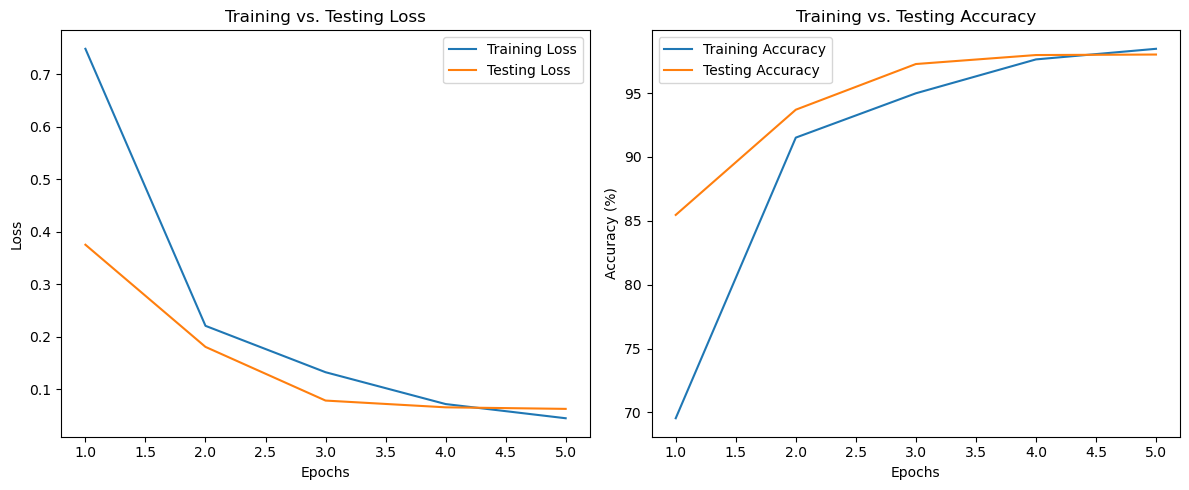

In [23]:
plot_training_results(results)

### Save and Load Model

In [24]:
def save_model(model, filepath):
    """
    Save the PyTorch model to the specified file path.

    Args:
    - model (torch.nn.Module): The model to save.
    - filepath (str): The file path where the model will be saved.
    """
    # Save the model's state dictionary (weights)
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

In [25]:
def load_model(model_class, filepath, device = "cpu"):
    """
    Load a PyTorch model from the specified file path.

    Args:
    - model_class (torch.nn.Module): The class of the model to load.
    - filepath (str): The file path from which to load the model.

    Returns:
    - model (torch.nn.Module): The loaded model with the saved weights.
    """
    # Initialize the model
    model = model_class()

    # Load the model weights into the initialized model
    model.load_state_dict(torch.load(filepath))
    model.to(device)  # Move the model to the desired device
    model.eval()  # Set the model to evaluation mode (optional, if you want to perform inference)
    
    print(f"Model loaded from {filepath}")
    
    return model

In [26]:
save_model(cnn_model, "./model/baseline_model.pth")

Model saved to ./model/baseline_model.pth


In [27]:
loaded_model = load_model(baseline_CNN, "./model/baseline_model.pth", device = device)

Model loaded from ./model/baseline_model.pth
